# Creating an optimal Molecule's Potential Energy Curve using Adapt-VQE

The main idea is to create an iterator that manipulates the C-NOT quantity and circuit depth to implement a VQE on a more efficient way. We are using as an example of implementation the energy curve for a molecule pair.  

In [ ]:
#import time
import matplotlib.pyplot as plt
import numpy as np
import itertools
from classiq import *
from classiq.applications.chemistry import ChemistryExecutionParameters,HEAParameters,Molecule,MoleculeProblem,UCCParameters
from classiq.execution import OptimizerType
from classiq.applications.combinatorial_helpers.pauli_helpers.pauli_utils import pauli_operator_to_hamiltonian
from classiq.qmod.symbolic import ceiling as ceiling_qmod, pi
#authenticate(overwrite=True)

/home/dacc/anaconda3/lib/python3.12/site-packages/classiq/_internals/authentication/token_manager.py:93: UserWarning: Overwriting an existing refresh token should only be done if it is compromised. Make sure this operation is necessary, and if not, remove the call to device registration.
  warnings.warn(


Your user code: ZJKD-LVWV
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=ZJKD-LVWV
Abriendo en una sesión existente del navegador



## 0. Define Molecules
We start this defining some examples of molecular pairs and triplets.

In [78]:
num1, start1, stop1 = 7, 0.20, 1   #First Linear Space 
num2, start2, stop2 = 6, 1.4, 3  #Second Linear Space
distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2)) # prepare x,y vectors
#molecules_LiH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, x))]) for x in distance]
#molecules_FH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("F", (0.0, 0.0, x))]) for x in distance]
molecules_H2 = [Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, x))]) for x in distance]
#molecules_O2 = [Molecule(atoms=[("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, x))]) for x in distance]
#molecules_H2O = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y) in itertools.product(distance,distance)]
#molecules_H3 = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
#molecules_O3 = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("O", (0, x, y)), ("O", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
#molecules_BeH2 = [Molecule(atoms=[("Be", (0.0, 0.0, 0.0)), ("H", (0, 0, x)), ("H", (0, 0, -x))]) for x in distance]

## 1. Vanilla VQE
This part would imitate the model of VQE already implemented on Classiq

In [79]:
VQE_energy, HF_energy, exact_energy = [],[],[]
qmods, qprogs, results, durations = [],[],[],[]
for k in range(len(distance)):
    molecule = molecules_H2[k]
    chemistry_problem = MoleculeProblem(molecule=molecule,mapping="jordan_wigner",z2_symmetries=True,freeze_core=True)  # jordan_wigner or bravyi_kitaev
    qmod = construct_chemistry_model(
        chemistry_problem=chemistry_problem,use_hartree_fock=True,ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=10,initial_point=None))
    qmods.append(qmod)
    qprog = synthesize(qmod);qprogs.append(qprog)
    result = execute(qprog).result();results.append(result)
    chemistry_result_dict = result[1].value
    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
    VQE_energy.append(chemistry_result_dict["total_energy"])
    HF_energy.append(chemistry_result_dict["hartree_fock_energy"])
    exact_energy.append(result_exact)

# 2. Define AdaptVQE 
In this part of the notebook, we implement the aVQE function, that depends of the array of points we want to calculate, the molecule pair we are modelling, and a threshold number. While the distance between the VQE and the exact solution arrays is bigger than the threshold, it will be relaxed the limit used. This process will be done until the distance is lesser than the threshold. 

In [80]:
def aVQE(x, molecules,threshold=0.01):
    m_depth, m_cnot =10, 10
    final_energy=[0 for i in range (len(x))]
    while(np.linalg.norm(np.array(final_energy)-np.array(exact_energy)) >= threshold):
        final_energy=[]
        for k in range(len(x)):
            molecule = molecules[k]
            gs_problem = MoleculeProblem(molecule=molecule,basis="sto3g",mapping="bravyi_kitaev",z2_symmetries=True,freeze_core=True) # jordan_wigner or bravyi_kitaev 
            qmod = construct_chemistry_model(
                chemistry_problem=gs_problem,use_hartree_fock=True,ansatz_parameters=UCCParameters(excitations=[1, 2]),
                execution_parameters=ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=10,initial_point=None))
            preferences = Preferences(optimization_level=3)
            constraints= Constraints(max_depth=m_depth, max_gate_count={TranspilerBasisGates.CX: m_cnot})
            qmods.append(qmod)
            qprog = synthesize(qmod, constraints=constraints, preferences=preferences);qprogs.append(qprog)
            result = execute(qprog).result();results.append(result)
            chemistry_result_dict = result[1].value
            operator = chemistry_problem.generate_hamiltonian()
            mat = operator.to_matrix()
            w, v = np.linalg.eig(mat)
            result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
            final_energy.append(chemistry_result_dict["total_energy"])
        m_depth=m_depth+10; m_cnot=m_cnot+10
    return final_energy
aVQE_energy=aVQE(distance,molecules_H2,0.1)
print(aVQE_energy)

[0.15428657663584033, -0.7419059549065443, -1.0142439732413888, -1.124117525404988, -1.1367621209698489, -1.1349652017067426, -1.0952813405083086, -1.0256438795557616, -0.964154878711613, -0.9493087607771638, -0.9368824544309751, -0.9337884254079105, -0.9334256449558986]


## 3. Plot and comparing results

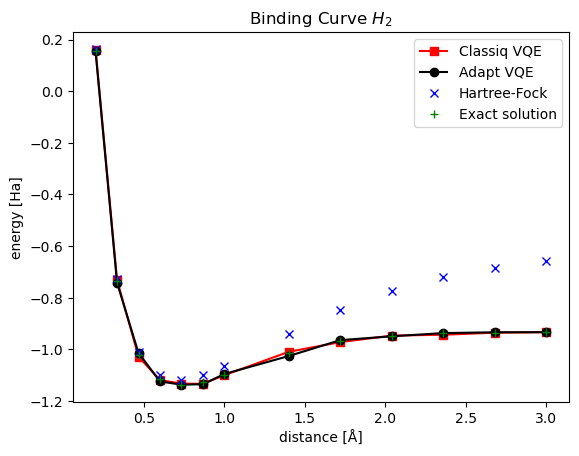

In [81]:
#write_qmod(qmods[-1], "adapt_vqe_energy_curve") # save the last model to a qmod file
#print(aVQE_energy)
plt.plot(distance, VQE_energy, "r-s", distance, aVQE_energy, "k-o", distance, HF_energy, "bx", distance, exact_energy, "g+")
plt.xlabel(r"distance [Å]")
plt.ylabel("energy [Ha]")
plt.legend(["Classiq VQE", "Adapt VQE", "Hartree-Fock", "Exact solution"])
plt.title(r"Binding Curve $H_{2}$")
plt.show()

In [ ]:
#m1=min(VQE_energy); print(m1)
#m2=min(aVQE_energy); print(m2)
#m3=min(HF_energy); print(m3)
#m4=min(exact_energy); print(m4)
#print('----')
#print(-100*np.abs(m1-m4)/m4)
#print(-100*np.abs(m2-m4)/m4)
#print(-100*np.abs(m3-m4)/m4)
#}}..0000print(np.linalg.no0rm(np.array(aVQE_energy)-np.array(exact_energy)))